## Введение в анализ данных, ИАД-2

## НИУ ВШЭ, 2019-20 учебный год

### Домашнее задание №2

Задание выполнил: Кувайцев Константин

### Общая информация

__Дата выдачи:__ 04.03.2019

__Дедлайн:__ 23:59 17.03.2019

### Оценивание и штрафы

Оценка за ДЗ вычисляется по следующей формуле:

$$
\text{points} \times 10 / \text{max points},
$$

где points — количество баллов, которое вы набрали, max_points - максимальное число баллов за задание. Бонусные задания отмечены звездочками (*)

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 1 балл в день, но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/).


# kNN своими руками (4)

Реализуйте взвешенный алгоритм kNN для регрессии. Пусть нам нужно вычислить значение $y$ для некоторого $x$ при известных данных $\left(x_1, y_1\right), \ldots, \left(x_\ell, y_\ell\right)$. Предсказанием вашего регрессора будет являться

$$
\hat{y} = \frac{\sum\limits_{i=1}^kw_iy_{(i)}}{\sum\limits_{i=1}^kw_i},
$$
где $\left(x_{(1)}, y_{(1)}\right), \ldots, \left(x_{(k)}, y_{(k)}\right)$ - ближайшие $k$ объектов к $x$ по некоторой метрике $d(\cdot, \cdot)$, а $w_i = \frac{1}{d\left(x, x_{(i)}\right)}$. Ваш алгоритм должен уметь работать с двумя метриками:

$$
d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_2 = \sqrt{\sum\limits_{j=1}^n\left(x_{(i)}^j - x^j\right)^2}\qquad\text{(евклидова)}
$$
$$
d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_1 = \sum\limits_{j=1}^n\left|x_{(i)}^j - x^j\right|\qquad\text{(манхэттена)}
$$

Сверьте для нескольких комбинаций различных параметров свой результат на искусственной выборке с результатом соответствующего алгоритма из `sklearn` по метрике качества MSE.

In [219]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression
from sklearn.linear_model import LinearRegression as LR, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder, normalize

%matplotlib inline

In [220]:
def distance_euclid(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def distance_manhattan(x1, x2):
    return np.sum(abs(x1 - x2))

class KNN:
    def __init__(self, metric='euclid', k=5):
        self.metric = metric
        self.k = k
        
        self.X_train = None
        self.y_train = None
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        return self
        
    def predict(self, X_test):  
        y_pred = [self.predict_calc(x) for x in X_test]
        return np.array(y_pred)
    
    def predict_calc(self, x):
        
        # Нахождение расстояния для элемента X_test до каждого элемента X_train
        distances = []
        if self.metric == 'euclid':
            for x_train in self.X_train:
                distances.append(distance_euclid(x, x_train))
        
        else:
            for x_train in self.X_train:
                distances.append(distance_manhattan(x, x_train))
        
        # Нахождение весов
        weights = np.array([1 / dist for dist in distances])
        np.flip(weights)
                
        k_idx = np.argsort(distances)[:self.k]
        k_values = [self.y_train[i] for i in k_idx]
        k_weights = [weights[i] for i in k_idx]
        
        # Предсказание целевой переменной
        y_pred_den = 0
        y_pred_num = 0

        for i in range(self.k):
            y_pred_den += k_values[i] * k_weights[i]
            y_pred_num += k_weights[i]
        
        y_pred = y_pred_den / y_pred_num
        
        return y_pred

In [221]:
np.random.seed(17032019)
X_train = np.random.randn(1000, 50)
y_train = np.random.randn(1000,)
X_test = np.random.randn(500, 50)
y_test = np.random.randn(500,)

In [222]:
knn = KNN(metric = 'euclid', k = 5)
knn.fit(X_train, y_train)
y1_pred = knn.predict(X_test)

In [223]:
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train, y_train)
y2_pred = neigh.predict(X_test)
print('MSE KNN sklearn: ', mean_squared_error(y_test, y2_pred))
print('MSE KNN своими руками: ', mean_squared_error(y_test, y1_pred))

MSE KNN sklearn:  1.143019350619603
MSE KNN своими руками:  1.143364989935662


# Линейная регрессия своими руками (4)

Реализуйте линейную регрессию с градиентным спуском для [функции потерь Хьюбера](https://en.wikipedia.org/wiki/Huber_loss):

$$
L_\delta\left(y, \hat{y}\right) =
\begin{cases}
\frac{1}{2}\left(y - \hat{y}\right)^2, \qquad &|y - \hat{y}| \leq \delta\\
\delta\left|y - \hat{y}\right| - \frac{1}{2}\delta^2,\qquad & \text{otherwise}
\end{cases}
$$

В таком случае общее значение функции потерь на всем датасете $(x_1, y_1), \ldots, (x_\ell, y_\ell)$ будет равно

$$
L = \frac{1}{\ell}\sum\limits_{i=1}^\ell L_\delta\left(y_i, \hat{y}_i\right)
$$

Проверьте работу вашего метода: выведите результаты его работы на той же искусственной выборке, что и в задаче выше (в качестве метрик качества используйте MSE и Huber loss). Постройте график зависимости значения функции потерь от итерации градиентного спуска.

*Вы можете опустить единичный признак в модели и не добавлять его в данные. Для данной искусственной выборки это не актуально, потому что целевая переменная в этом случае является случайной величиной из стандартного нормального распределения со средним 0.*

*Вектор весов в градиентном спуске можете инициализировать нулями.*

In [224]:
class LinearRegressionHuber:
    def __init__(self, delta=1.0, max_iter=1000, tol=1e-6, eta=1e-2):
        """
        PARAMETERS:
        delta - scalar in Huber loss
        max_iter - maximum possible number of iterations in Gradient Descent
        tol - precision for stopping criterion in Gradient Descent
        eta - step size in Gradient Descent
        """
        
        self.delta = delta
        self.max_iter = max_iter
        self.tol = tol
        self.eta = eta
        
        self.w = None
        self.loss_history = None
        
    def fit(self, X_train, y_train):
        self.loss_history = []
        d = X_train.shape[1]
        self.w = np.random.randn(d,)
        w_old = np.ones(d,)
        
        step = 0
        while distance_euclid(w_old, self.w) >= self.tol or step < self.max_iter:
            w_per = cp.deepcopy(self.w)
            self.w = self.w - self.eta * self.calc_gradient(X_train, y_train)
            w_old = w_per
            
            self.loss_history.append(self.calc_loss(X_train, y_train))
            step += 1
        
        return self.loss_history
        
    def predict(self, X_test):
        y_pred = np.dot(X_test, self.w)
        return y_pred

    
    def calc_gradient(self, X, y):
        l = X.shape[0]
        trans_X = X.transpose()
        prediction = self.predict(X)
        grad = (2 / l) * X.T.dot((prediction - y))
        return grad
            
        
    def calc_loss(self, X, y):
        y_pred = self.predict(X)
        loss = []
        
        for i in range(y.shape[0]):
            if abs(y_pred[i] - y[i]) <= self.delta:
                loss_elem = 0.5 * (y[i] - y_pred[i])
            else:
                loss_elem = self.delta * abs(y[i] - y_pred[i]) - 0.5 * self.delta**2
            
            loss.append(loss_elem)
                    
        return np.sum(loss) / len(y_pred)

In [225]:
k = LinearRegressionHuber()
Loss = k.fit(X_train, y_train)

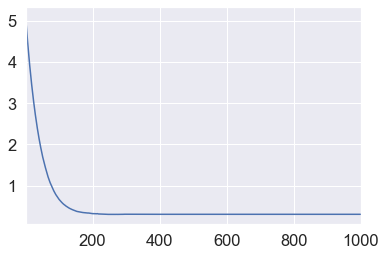

In [226]:
plt.plot(Loss)
plt.xlim([1, 1000])
plt.show()

In [227]:
pred = LR().fit(X_train, y_train)
y3_pred = k.predict(X_test)
y4_pred = pred.predict(X_test)

In [228]:
print('MSE LR руками: ', mean_squared_error(y_test ,y3_pred))
print('MSE LR sklearn: ', mean_squared_error(y_test ,y4_pred))

MSE LR руками:  1.0854003966399186
MSE LR sklearn:  1.0882539618811702


In [229]:
 print('Calc_loss: ', k.calc_loss(X_train, y_train))

Calc_loss:  0.3104434999463284


# Практика

Пожалуйста, при использовании различных функций из библиотек импортируйте все, что вам понадобилось в данной части, в следующем блоке:

В этом домашнем задании вы поработаете с данными из другого соревнования на Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques. Задача - предсказание цены дома.

In [230]:
data = pd.read_csv('train.csv', header=0)

In [231]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [232]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [233]:
data.drop('Id', axis=1, inplace=True)

## 1 (1)

Есть ли в данных пропуски? Если да, то для каждого столбца, в котором они имеются, посчитайте их количество и их долю от общего числа значений. Что вы наблюдаете?

In [234]:
l = data.shape[0]
columns_nan = []
values = {
    "Количество NaN": [],
    "Доля от общего числа": []
}
for i in range(len(data.columns)):
    column = data.columns[i]
    if data[column].isna().sum() != 0:
        columns_nan.append(column)
        nan_val = data[column].isna().sum()
        values["Количество NaN"].append(nan_val)
        values["Доля от общего числа"].append(nan_val / l)
answer = pd.DataFrame(data=values, index=columns_nan)
answer

,Количество NaN,Доля от общего числа
LotFrontage,259,0.177397
Alley,1369,0.937671
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
BsmtQual,37,0.025342
BsmtCond,37,0.025342
BsmtExposure,38,0.026027
BsmtFinType1,37,0.025342
BsmtFinType2,38,0.026027
Electrical,1,0.000685


## 2 (1)

Избавьтесь от пропусков. Для каждого из примененных методов обоснуйте свое решение. **Проверьте, что вы действительно избавились от пропусков.**

*Напоминание. В зависимости от типа столбца, можно заполнить пропуски, например, средним арифметическим, медианой, модой, можно какими-то отдельными значениями. А можно такие столбцы вообще удалить.*

Alley, PoolQC, Fence, FireplaceQu и MiscFeature нужно удалить, так как в этих столбцах большая доля пропусков

In [235]:
data.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu'], axis=1, inplace=True)

Столбцы с типом float(LotFrontage, MasVnrArea, GarageYrBlt) заполним средним значением

In [236]:
data.LotFrontage = data.LotFrontage.fillna(data.LotFrontage.mean())
data.MasVnrArea = data.MasVnrArea.fillna(data.MasVnrArea.mean())
data.GarageYrBlt = data.GarageYrBlt.fillna(data.GarageYrBlt.mean())

В колонках BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond NaN значение означает отсутствие признака (отсутствие гаража или цокольного этажа), поэтому NaN можно заменить на Absence (отсутствие).

In [237]:
columns_nan = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
     'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for column in columns_nan:
    data[column] = data[column].fillna('Absence')

Остались MasVnrType и Elecrical. Заполним их модой

In [238]:
data.Electrical = data.Electrical.fillna(data.Electrical.mode()[0])
data.MasVnrType = data.MasVnrType.fillna(data.MasVnrType.mode()[0])

In [239]:
data.isna().any().any()

False

## 3 (1)

Обработайте категориальные признаки. В их обнаружении вам может помочь синтаксис `pandas` (например, можно обратить внимание на типы столбцов), а также описание датасета и его исследование. Объясните выбор метода (one-hot-encoding, label encoding, ...)

In [241]:
# YearBuilt изменим следующим образом: 
# изменим год построения на количество лет после постройки самого старого дома в датасете
data['YearBuilt'] = data['YearBuilt'] - data['YearBuilt'].min()
# Данный шаг позволит придать больший вес (большую цену) новым домам, что в принципе логично

In [242]:
# GarageYrBlt изменим следующим образом: 
# изменим год постройки гаража на количество лет после постройки самого старого гаража в датасете
data['GarageYrBlt'] = data['GarageYrBlt'] - data['GarageYrBlt'].min()
# Данный шаг позволит придать больший вес (большую цену) новым  гаражам

In [243]:
# YearRemodAdd изменим следующим образом: 
# изменим год ремонта на количество лет после самого первого ремонта в датасете
data['YearRemodAdd'] = data['YearRemodAdd'] - data['YearRemodAdd'].min()
# Данный шаг позволит придать больший вес (большую цену) свежим ремонтам

In [244]:
# Везде где признак показывает то или иное качество,
# его можно заменить на числовое отображение, где бОльшая цифра означает лучшее качество 
data = data.replace(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'Absence'], [5, 4, 3, 2, 1, 0])

In [245]:
# CentralAir заменим Y на 1, а N на 0
data['CentralAir'] = data['CentralAir'].replace(['Y', 'N'], [1, 0])

In [246]:
# Посмотрим на корреляцию признаков с ценой
abs(data.corrwith(data['SalePrice'])).sort_values()

BsmtFinSF2       0.011378
BsmtHalfBath     0.016844
ExterCond        0.018899
MiscVal          0.021190
LowQualFinSF     0.025606
YrSold           0.028923
3SsnPorch        0.044584
MoSold           0.046432
OverallCond      0.077856
MSSubClass       0.084284
PoolArea         0.092404
ScreenPorch      0.111447
EnclosedPorch    0.128578
KitchenAbvGr     0.135907
BedroomAbvGr     0.168213
BsmtCond         0.212607
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
CentralAir       0.251328
GarageCond       0.263191
LotArea          0.263843
GarageQual       0.273839
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.334901
BsmtFinSF1       0.386420
HeatingQC        0.427649
Fireplaces       0.466929
GarageYrBlt      0.470177
MasVnrArea       0.475241
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
BsmtQual         0.585207
1stFlrSF         0.605852
TotalBsmtSF 

In [247]:
# MoSold, YrSold, SaleCondition, MSSubClass, BsmtFinSF2, BsmtHalfBath, ExterCond, 
# MiscVal, LowQualFinSF, 3SsnPorch удалим,
# так как корреляция очень низка или ее нет
data.drop(['MoSold', 'YrSold', 'SaleCondition', 'MSSubClass', 'BsmtFinSF2',
           'BsmtHalfBath', 'ExterCond', 'MiscVal', 'LowQualFinSF', '3SsnPorch'], axis=1, inplace=True)

In [248]:
type_int = data['SalePrice'].dtypes
type_float = data['LotFrontage'].dtypes
for column in data.columns:
    column_type = data[column].dtypes
    if (column_type == type_int or column_type == type_float) and column != 'SalePrice':
        data[column] = (data[column] - data[column].mean()) / data[column].std()

In [249]:
data_dum = pd.get_dummies(data)
print(data_dum.shape)
data_dum

(1460, 232)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtCond,...,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,-2.292932e-01,-0.207071,0.651256,-0.517023,1.050634,0.878367,0.511243,1.051942,0.582968,0.117844,...,1,0,0,0,0,0,0,0,0,1
1,4.517813e-01,-0.091855,-0.071812,2.178881,0.156680,-0.429430,-0.574214,-0.689368,0.582968,0.117844,...,1,0,0,0,0,0,0,0,0,1
2,-9.307829e-02,0.073455,0.651256,-0.517023,0.984415,0.829930,0.322950,1.051942,0.582968,0.117844,...,1,0,0,0,0,0,0,0,0,1
3,-4.563180e-01,-0.096864,0.651256,-0.517023,-1.862993,-0.720051,-0.574214,-0.689368,-0.557961,1.928918,...,1,0,0,0,0,0,0,0,0,1
4,6.334012e-01,0.375020,1.374324,-0.517023,0.951306,0.733056,1.364102,1.051942,0.582968,0.117844,...,1,0,0,0,0,0,0,0,0,1
5,6.788061e-01,0.360493,-0.794879,-0.517023,0.719540,0.490872,-0.574214,-0.689368,0.582968,0.117844,...,1,0,0,0,0,0,0,0,0,1
6,2.247565e-01,-0.043364,1.374324,-0.517023,1.083743,0.975241,0.455863,1.051942,1.723898,0.117844,...,1,0,0,0,0,0,0,0,0,1
7,1.032389e-14,-0.013508,0.651256,0.381612,0.057352,-0.574741,0.754917,-0.689368,0.582968,0.117844,...,1,0,0,0,0,0,0,0,0,1
8,-8.649627e-01,-0.440508,0.651256,-0.517023,-1.333243,-1.688790,-0.574214,-0.689368,-0.557961,0.117844,...,1,0,0,0,0,0,0,0,0,1
9,-9.103677e-01,-0.310264,-0.794879,0.381612,-1.068368,-1.688790,-0.574214,-0.689368,-0.557961,0.117844,...,1,0,0,0,0,0,0,0,0,1


In [250]:
print(abs(data_dum.corrwith(data_dum['SalePrice'])).sort_values())

BsmtFinType2_GLQ        0.000076
RoofMatl_Metal          0.000304
RoofStyle_Mansard       0.000308
Foundation_Wood         0.002711
Condition2_RRAe         0.002993
BldgType_TwnhsE         0.003804
LotConfig_Corner        0.004145
Condition1_RRNe         0.004584
RoofMatl_Tar&Grv        0.004921
Condition1_RRAn         0.005893
LotConfig_FR2           0.006859
RoofMatl_ClyTile        0.006897
Foundation_Stone        0.012103
Utilities_AllPub        0.014314
Utilities_NoSeWa        0.014314
SaleType_ConLI          0.014371
RoofMatl_Roll           0.014479
Condition2_RRAn         0.014510
Neighborhood_SawyerW    0.014560
Functional_Mod          0.016073
RoofStyle_Flat          0.016433
Exterior2nd_Stone       0.016754
Functional_Sev          0.017116
Exterior1st_Plywood     0.017719
LotConfig_FR3           0.018186
Neighborhood_Blmngtn    0.019066
SaleType_CWD            0.019588
RoofMatl_Membran        0.019970
Heating_GasW            0.020103
Neighborhood_Blueste    0.020250
          

## 4 (0.5)

Вычислите и визуализируйте попарную корреляцию Пирсона между всеми признаками. Какие выводы можно сделать?

*Для визуализации можно использовать `seaborn.heatmap()`.*

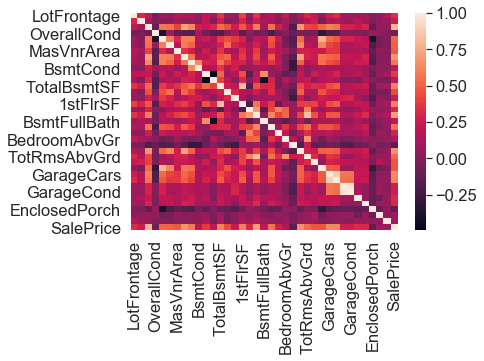

In [251]:
corr_pier = sns.heatmap(data.corr())

## 5 (0.5)

Найдите признаки с максимальным и минимальным **абсолютным** значением коэффициента корреляции Пирсона с предсказываемым значением. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

*Не забудьте указать название графика и обозначить, что изображено по каждой из осей.*

In [252]:
corr_SP = data_dum.corrwith(data['SalePrice'])
corr = abs(corr_SP).sort_values()
print(corr)

BsmtFinType2_GLQ        0.000076
RoofMatl_Metal          0.000304
RoofStyle_Mansard       0.000308
Foundation_Wood         0.002711
Condition2_RRAe         0.002993
BldgType_TwnhsE         0.003804
LotConfig_Corner        0.004145
Condition1_RRNe         0.004584
RoofMatl_Tar&Grv        0.004921
Condition1_RRAn         0.005893
LotConfig_FR2           0.006859
RoofMatl_ClyTile        0.006897
Foundation_Stone        0.012103
Utilities_AllPub        0.014314
Utilities_NoSeWa        0.014314
SaleType_ConLI          0.014371
RoofMatl_Roll           0.014479
Condition2_RRAn         0.014510
Neighborhood_SawyerW    0.014560
Functional_Mod          0.016073
RoofStyle_Flat          0.016433
Exterior2nd_Stone       0.016754
Functional_Sev          0.017116
Exterior1st_Plywood     0.017719
LotConfig_FR3           0.018186
Neighborhood_Blmngtn    0.019066
SaleType_CWD            0.019588
RoofMatl_Membran        0.019970
Heating_GasW            0.020103
Neighborhood_Blueste    0.020250
          

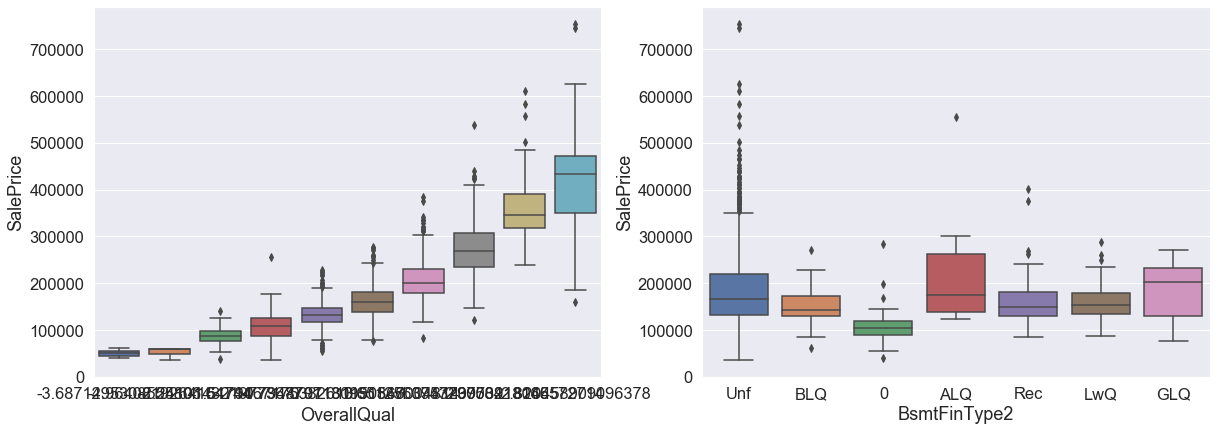

In [253]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

# Корреляция максимальна (0.790982) между SalePrice и OverallQual
fig1 = fig.add_subplot(221)
sns.boxplot(x = data.OverallQual, y = data.SalePrice)

# Корреляция минимальна (0.011378) между SalePrice и BsmtFinType2
fig2 = fig.add_subplot(222)
sns.boxplot(x = data.BsmtFinType2, y = data.SalePrice)

## 6 (0.5)

Постройте гистограмму распределения предсказываемого значения. Для избавления от разницы в масштабах, а также «смещения» распределения переменной в сторону нормального (что бывает полезно при статистическом анализе), можно прологарифмировать ее (это обратимое преобразование, поэтому целевую переменную легко восстановить). В данном случае воспользуйтесь `numpy.log1p`, чтобы сделать преобразование $y \to \ln\left(1 + y\right)$. Постройте гистограмму распределения от нового предсказываемого значения. Опишите наблюдения.

*В дальнейшем используйте в качестве предсказываемого значения вектор, который получился после логарифмирования.*

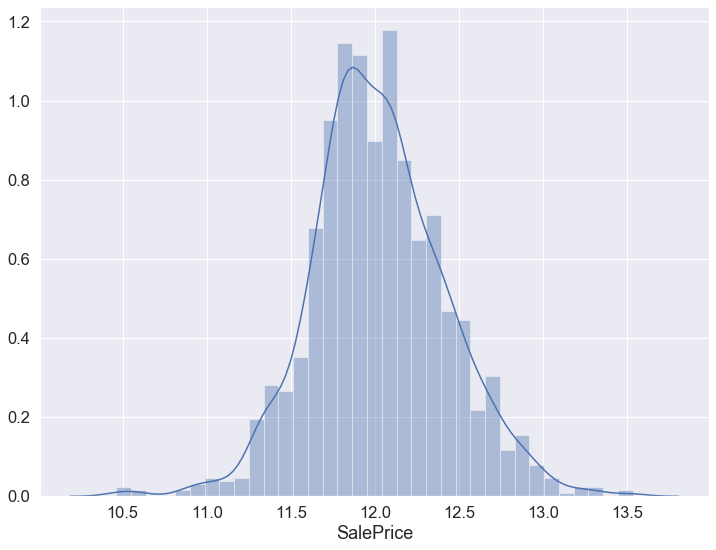

In [254]:
fig = plt.figure(figsize=(12, 9))
sns_plot = sns.distplot(np.log1p(data['SalePrice']))
fig = sns_plot.get_figure()

Перейдем непосредственно к построению моделей. Разобьем выборку на обучение и контроль.

*Пожалуйста, **не меняйте** значение `random_state` в следующей ячейке.*

In [255]:
sp_train = data_dum['SalePrice']
data_dum.drop('SalePrice', axis=1, inplace=True)

In [282]:
X_train, X_val, y_train, y_val = train_test_split(data_dum, np.log1p(sp_train), test_size=0.1, random_state=17032019)

In [283]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1314, 231), (146, 231), (1314,), (146,))

## 7 (2)

Примените к данным следующие алгоритмы:

- kNN
- линейная регрессия
- Lasso
- Ridge

Для каждого из методов подберите гиперпараметры с помощью кросс-валидации. Обучите алгоритмы с лучшими гиперпараметрами на обучающей выборке и оцените качество по метрике **Root** Mean Squared Error. Какой из методов показывает себя лучше?

## kNN

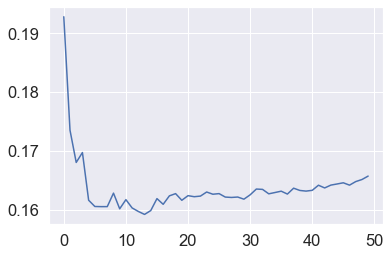

In [284]:
answer = []
for i in range(50):
    neigh = KNeighborsRegressor(n_neighbors=(i + 1))
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_val)
    answer.append(np.sqrt(mean_squared_error(y_val, y_pred)))
plt.plot(answer)
plt.show()

In [285]:
neigh = KNeighborsRegressor(n_neighbors=13)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_val)
answer.append(np.sqrt(mean_squared_error(y_val, y_pred)))
print('RMSE KNN sklearn: ', np.sqrt(mean_squared_error(y_val, y_pred)))

RMSE KNN sklearn:  0.1597062467433068


## Линейная регрессия

In [286]:
regression = LR().fit(X_train, y_train)
y_pred = regression.predict(X_val)
print('RMSE LR sklearn: ', np.sqrt(mean_squared_error(y_val, y_pred)))

RMSE LR sklearn:  0.1235572476054005


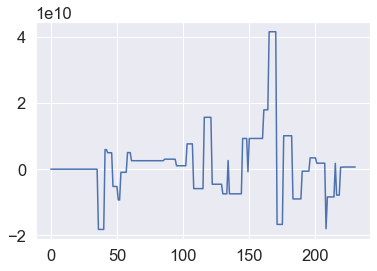

In [287]:
plt.plot(regression.coef_)
plt.show()

## Lasso

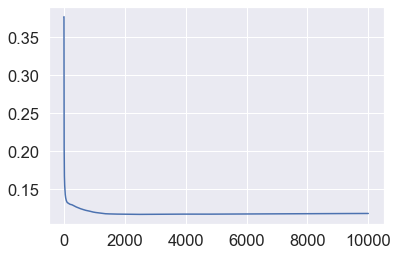

In [297]:
# Найдем оптимальное значение alpha
answer = []
for i in range(1, 10000):
    lasso = Lasso(alpha=1/i, max_iter=1000).fit(X_train, y_train)
    y_pred = lasso.predict(X_val)
    answer.append(np.sqrt(mean_squared_error(y_val, y_pred)))
plt.plot(answer)
plt.show()

In [296]:
lasso = Lasso(alpha=0.0004, max_iter=10000).fit(X_train, y_train)
y_pred = lasso.predict(X_val)
print('RMSE Lasso sklearn: ', np.sqrt(mean_squared_error(y_val, y_pred)))

RMSE Lasso sklearn:  0.11700024144844708


Оптимальное значение alpha = 0.0004

## Ridge

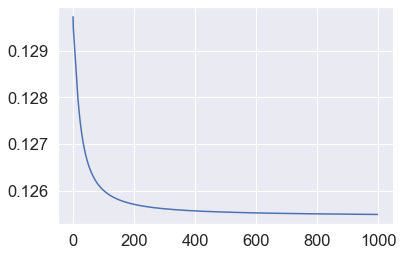

In [280]:
# Найдем оптимальное значение alpha
answer = []
for i in range(1, 1000):
    ridge = Ridge(alpha=10/(i), max_iter=2000).fit(X_train, y_train)
    y_pred = ridge.predict(X_val)
    answer.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    #print('RMSE Ridge sklearn: ', np.sqrt(mean_squared_error(y_val, y_pred)))
plt.plot(answer)
plt.show()

In [281]:
ridge = Ridge(alpha=0.001, max_iter=10000, fit_intercept = True).fit(X_train, y_train)
y_pred = ridge.predict(X_val)
answer.append(np.sqrt(mean_squared_error(y_val, y_pred)))
print('RMSE Ridge sklearn: ', np.sqrt(mean_squared_error(y_val, y_pred)))


RMSE Ridge sklearn:  0.12545480560495553


Оптимальное значение alpha = 0.001

### RMSE Lasso = 0.11700024144844708

## 8 (1)

Постройте гистограммы значений весов для линейной регрессии, Lasso и Ridge. Опишите наблюдения. В чем различия между полученными наборами весов и почему?

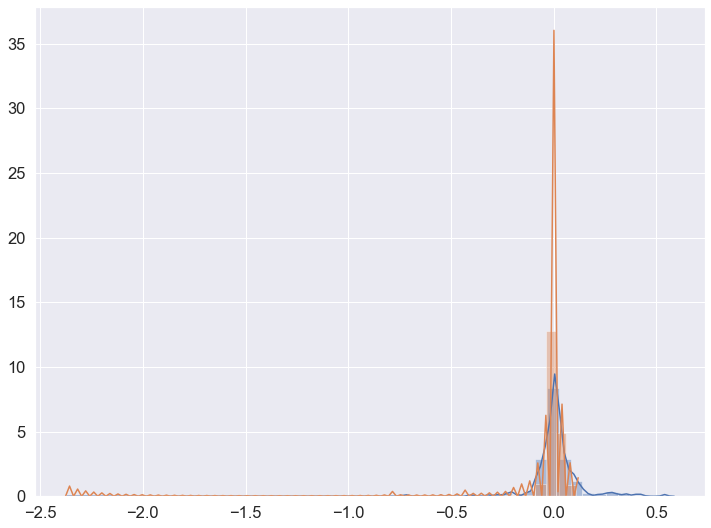

In [298]:
fig = plt.figure(figsize=(12, 9))
sns_plot1 = sns.distplot(ridge.coef_)
sns_plot2 = sns.distplot(lasso.coef_)
fig = sns_plot1.get_figure()
fig = sns_plot2.get_figure()

## 9 (0.5)

Добейтесь того, чтобы в заданиях выше ваш лучший алгоритм давал качество не больше 0.125 на тестовых данных по метрике RMSE (если вы дошли до этого задания, а качество выше уже удовлетворяет этому условию, вы автоматически получите за него полный балл).

## 10* (0.5)

Добейтесь того, чтобы в заданиях выше ваш лучший алгоритм давал качество не больше 0.121 на тестовых данных по метрике RMSE. Для этого вы можете использовать самые разные методы, какие захотите - отбор признаков, генерация новых, разные способы предобработки данных. Единственное ограничение - не использовать никакие алгоритмы регрессии, кроме kNN, линейной регрессии, Lasso и Ridge.

In [ ]:
# your code here

# Теория

За данную часть можно получить бонусные баллы. Решения необходимо оформить в этом же файле в ячейках типа Markdown, пользуясь $\LaTeX$ для записи математических формул.

## 1* (0.5)

Найдите константу $C$, решающую следующую задачу ($0 < \tau < 1$ фиксировано):

$$
\sum\limits_{i=1}^\ell\rho_\tau\left(y_i - C\right) \to \min_C,
$$

где

$$
\rho_\tau(z) =
\begin{cases}
\tau z, & z > 0\\
(\tau - 1)z, & z \leq 0
\end{cases}
$$

*(your solution here)*